# 🧪 Super Resolución Clásica - Técnicas en Python
Este notebook muestra implementaciones prácticas de cinco técnicas clásicas de super resolución: 
1. Interpolación (bilineal y bicúbica)
2. Multi-frame Super Resolution (MFSR)
3. Sparse Representation
4. Edge-Directed Interpolation
5. Neighbor Embedding


In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from sklearn.neighbors import NearestNeighbors
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

## 1. Interpolación bilineal y bicúbica

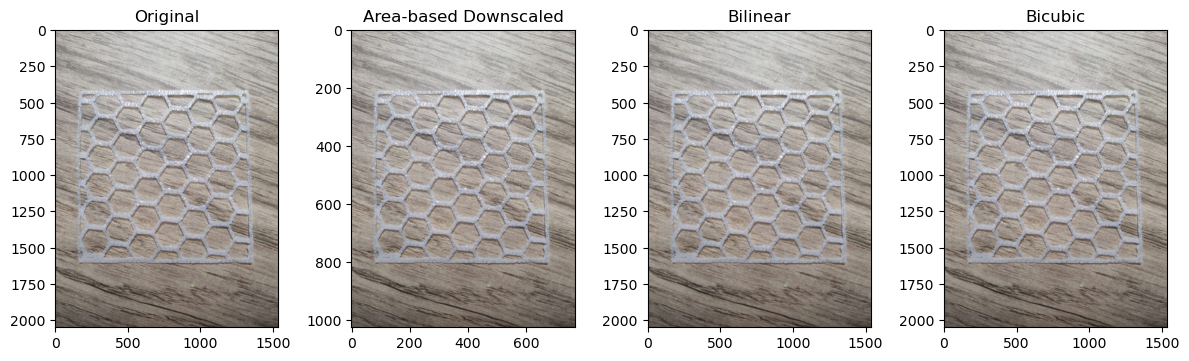

In [2]:
original = cv2.imread("printing.jpg")
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
downscaled_rgb = cv2.resize(original_rgb, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

bilinear = cv2.resize(downscaled_rgb, (original.shape[1], original.shape[0]), interpolation=cv2.INTER_LINEAR)
bicubic = cv2.resize(downscaled_rgb, (original.shape[1], original.shape[0]), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(12,4))
plt.subplot(1, 4, 1); plt.title("Original"); plt.imshow(original_rgb)
plt.subplot(1, 4, 2); plt.title("Area-based Downscaled"); plt.imshow(downscaled_rgb)
plt.subplot(1, 4, 3); plt.title("Bilinear"); plt.imshow(bilinear)
plt.subplot(1, 4, 4); plt.title("Bicubic"); plt.imshow(bicubic)
plt.tight_layout()
plt.show()

#### Evaluation

In [25]:
psnr_bilinear = psnr(original_rgb, bilinear)
psnr_bicubic = psnr(original_rgb, bicubic)
print(f"PSNR Bilinear: {psnr_bilinear:.2f} dB")
print(f"PSNR Bicubic: {psnr_bicubic:.2f} dB")

(ssim_bilinear, diff_bilinear) = ssim(original_rgb, bilinear, channel_axis=2, full=True)
(ssim_bicubic, diff_bicubic) = ssim(original_rgb, bicubic, channel_axis=2, full=True)
print(f"\nSSIM Bilinear: {ssim_bilinear:.4f}")
print(f"SSIM Bicubic: {ssim_bicubic:.4f}")

mse_bilinear = np.mean((original_rgb - bilinear) ** 2)
mse_bicubic = np.mean((original_rgb - bicubic) ** 2)
print(f"\nMSE Bilinear: {mse_bilinear:.2f}")
print(f"MSE Bicubic: {mse_bicubic:.2f}")

PSNR Bilinear: 38.91 dB
PSNR Bicubic: 39.89 dB

SSIM Bilinear: 0.9655
SSIM Bicubic: 0.9736

MSE Bilinear: 7.74
MSE Bicubic: 6.20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3866881876552339..1.0000000000012055].


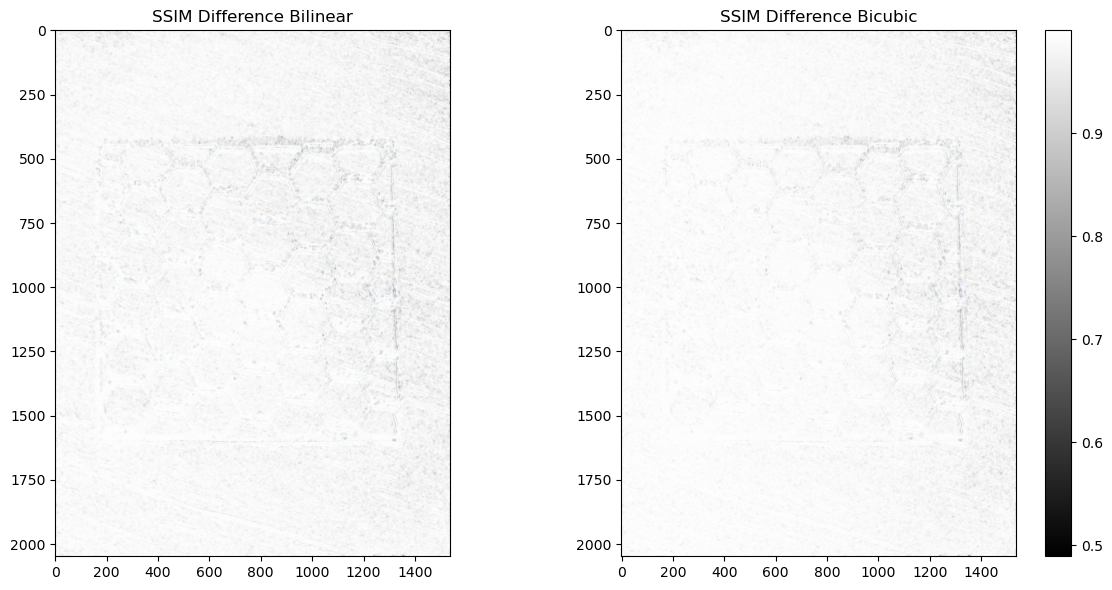

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("SSIM Difference Bilinear")
plt.imshow(diff_bilinear, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("SSIM Difference Bicubic")
plt.imshow(diff_bicubic, cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()

## 2. Iterative Back-Projection (IBP)

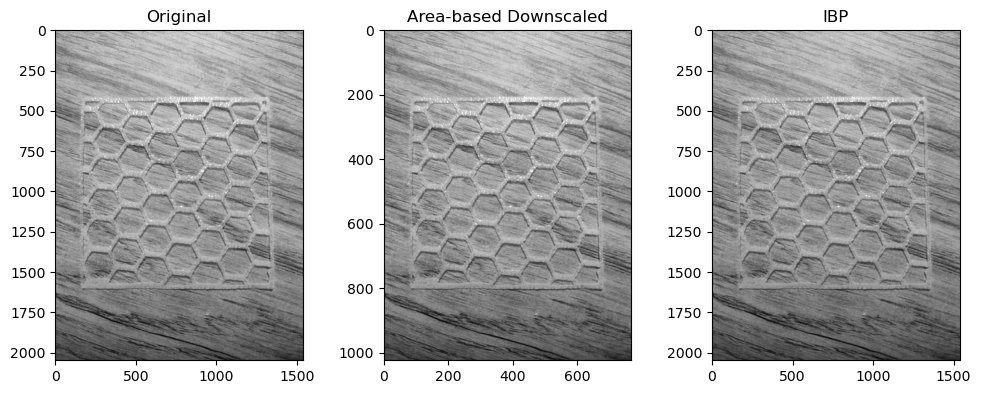

In [4]:
def back_projection(high_res, low_res, iterations=10):
    iterative_high_res = high_res.copy()
    psnr_scores, ssim_scores = [], []
    data_range = high_res.max() - high_res.min()
    
    for _ in range(iterations):
        down = cv2.resize(iterative_high_res, (low_res.shape[1], low_res.shape[0]), interpolation=cv2.INTER_LINEAR)
        diff = low_res - down
        diff_up = cv2.resize(diff, (iterative_high_res.shape[1], iterative_high_res.shape[0]), interpolation=cv2.INTER_LINEAR)
        iterative_high_res += diff_up
        
        psnr_scores.append(psnr(high_res, iterative_high_res, data_range=data_range))
        ssim_scores.append(ssim(high_res, iterative_high_res, data_range=data_range))
    
    return iterative_high_res, psnr_scores, ssim_scores

init_hr = cv2.imread('printing.jpg', cv2.IMREAD_GRAYSCALE)
low_res = cv2.resize(init_hr, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
hr, psnr_scores, ssim_scores = back_projection(init_hr.astype(np.float32), low_res.astype(np.float32))

plt.figure(figsize=(10,4))
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(init_hr, cmap='gray')
plt.subplot(1, 3, 2); plt.title("Area-based Downscaled"); plt.imshow(low_res, cmap='gray')
plt.subplot(1, 3, 3); plt.title("IBP"); plt.imshow(hr, cmap='gray')
plt.tight_layout()
plt.show()

#### Evaluation

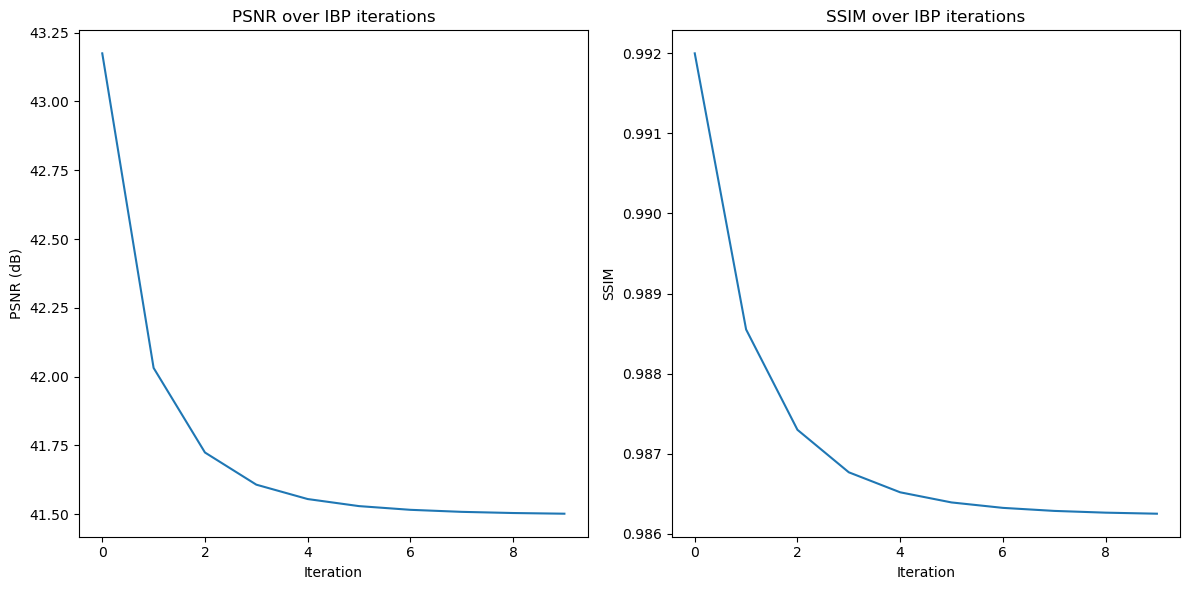

In [5]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(psnr_scores)
plt.title("PSNR over IBP iterations")
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")

plt.subplot(1, 2, 2)
plt.plot(ssim_scores)
plt.title("SSIM over IBP iterations")
plt.xlabel("Iteration")
plt.ylabel("SSIM")

plt.tight_layout()
plt.show()

## 3. Non-Local Means Super-Resolution

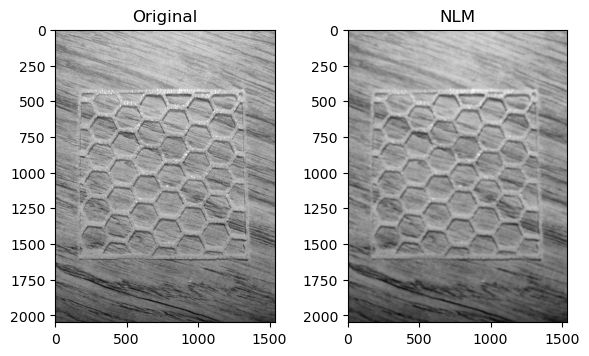

In [22]:
image = cv2.imread('printing.jpg', cv2.IMREAD_GRAYSCALE)

sigma_est = np.mean(estimate_sigma(image))

nlm = denoise_nl_means(img_as_float(image), h=1.15 * sigma_est, patch_size=5, patch_distance=6, fast_mode=True)

plt.figure(figsize=(6,4))
plt.subplot(1, 2, 1); plt.title("Original"); plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2); plt.title("NLM"); plt.imshow(nlm, cmap='gray')
plt.tight_layout()
plt.show()

#### Evaluation

PSNR NLM: 3.44 dB
SSIM NLM: 0.0042


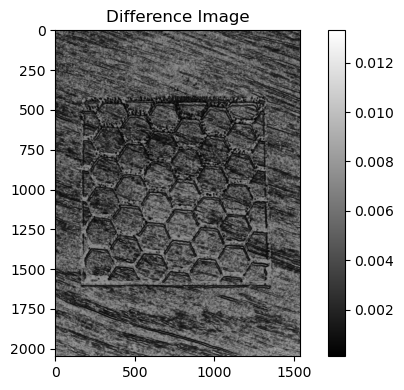

In [31]:
data_range = image.max() - image.min()

psnr_nlm = psnr(image, nlm, data_range=data_range)
print(f"PSNR NLM: {psnr_nlm:.2f} dB")

(ssim_value, diff) = ssim(image, nlm, full=True, data_range=data_range)
print(f"SSIM NLM: {ssim_value:.4f}")

plt.figure(figsize=(6, 4))
plt.title("Difference Image")
plt.imshow(diff, cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()

## 4. Edge-Guided Interpolation (EGI)

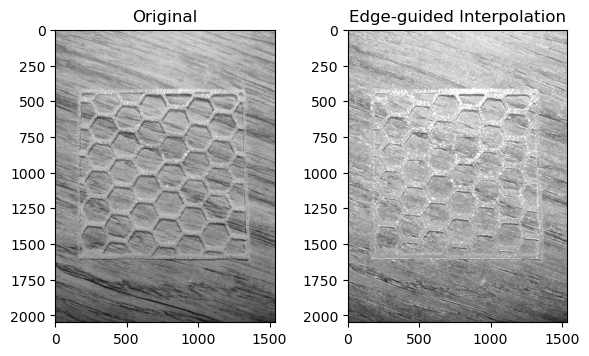

In [35]:
def edge_guided_interpolation(ground_truth, image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    edges = np.hypot(grad_x, grad_y)

    upscaled = cv2.resize(image, (ground_truth.shape[1], ground_truth.shape[0]), interpolation=cv2.INTER_LINEAR)
    up_edges = cv2.resize(edges, (upscaled.shape[1], upscaled.shape[0]))

    sharpened = cv2.addWeighted(upscaled, 1.0, up_edges.astype(np.uint8), 0.5, 0)
    
    return sharpened

image = cv2.imread('printing.jpg', cv2.IMREAD_GRAYSCALE)
low_res = cv2.resize(image, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

output = edge_guided_interpolation(image, low_res)

# Display the original and edge-guided interpolated images
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1); plt.title("Original"); plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2); plt.title("Edge-guided Interpolation"); plt.imshow(output, cmap='gray')
plt.tight_layout()
plt.show()

#### Evaluation

PSNR Edge-guided Interpolation: 16.88 dB
SSIM Edge-guided Interpolation: 0.5701


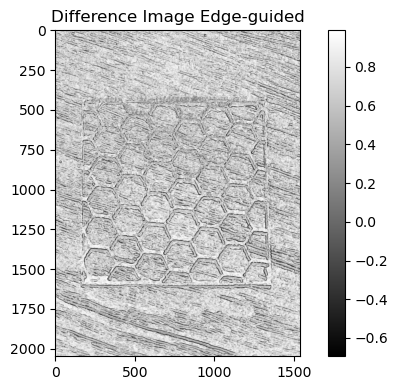

In [36]:
data_range = image.max() - image.min()

psnr_edge_guided = psnr(image, output, data_range=data_range)
print(f"PSNR Edge-guided Interpolation: {psnr_edge_guided:.2f} dB")

(ssim_edge_guided, diff_edge_guided) = ssim(image, output, full=True, data_range=data_range)
print(f"SSIM Edge-guided Interpolation: {ssim_edge_guided:.4f}")

plt.figure(figsize=(6, 4))
plt.title("Difference Image Edge-guided")
plt.imshow(diff_edge_guided, cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()

## 5. Frequency Domain Extrapolation

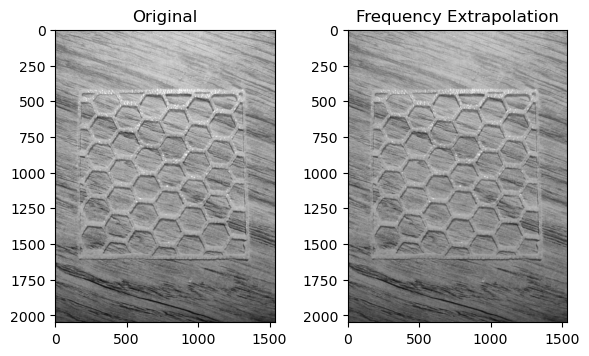

In [40]:
def frequency_extrapolation(ground_truth, image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    
    # Zero-padding in frequency domain (increasing resolution)
    rows, cols = image.shape
    pad_rows = ground_truth.shape[0]
    pad_cols = ground_truth.shape[1]
    f_padded = np.zeros((pad_rows, pad_cols), dtype=complex)
    center = (pad_rows // 2, pad_cols // 2)
    f_padded[center[0] - rows//2:center[0] + rows//2,
             center[1] - cols//2:center[1] + cols//2] = fshift
    
    # Inverse FFT
    f_ishift = np.fft.ifftshift(f_padded)
    img_upscaled = np.fft.ifft2(f_ishift)
    
    return np.abs(img_upscaled)

image = cv2.imread('printing.jpg', cv2.IMREAD_GRAYSCALE)
low_res = cv2.resize(image, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

freq_up = frequency_extrapolation(image, low_res)

# Display the original and frequency extrapolated images
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1); plt.title("Original"); plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2); plt.title("Frequency Extrapolation"); plt.imshow(freq_up, cmap='gray')
plt.tight_layout()
plt.show()

#### Evaluation

PSNR Frequency Extrapolation: 5.91 dB
SSIM Frequency Extrapolation: 0.3367


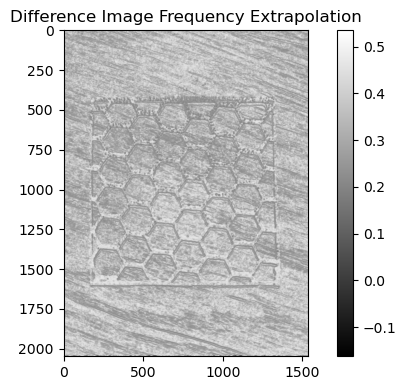

In [45]:
data_range = image.max() - image.min()

psnr_freq_extrapolation = psnr(image, freq_up, data_range=data_range)
print(f"PSNR Frequency Extrapolation: {psnr_freq_extrapolation:.2f} dB")

(ssim_freq_extrapolation, diff_freq_extrapolation) = ssim(image, freq_up, full=True, data_range=data_range)
print(f"SSIM Frequency Extrapolation: {ssim_freq_extrapolation:.4f}")

plt.figure(figsize=(6, 4))
plt.title("Difference Image Frequency Extrapolation")
plt.imshow(diff_freq_extrapolation, cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()